<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Major Neural Network Architectures Challenge
## *Data Science Unit 4 Sprint 3 Challenge*

In this sprint challenge, you'll explore some of the cutting edge of data science. This week we studied several famous neural network architectures: 
recurrent neural networks (RNNs), long short-term memory (LSTMs), convolutional neural networks (CNNs), and Generative Adverserial Networks (GANs). In this sprint challenge, you will revisit these models. Remember, we are testing your knowledge of these architectures, not your ability to fit a model with high accuracy. 

__*Caution:*__  These approaches can be pretty heavy computationally. All problems were designed so that you should be able to achieve results within at most 5-10 minutes of runtime on Colab or a comparable environment. If something is running longer, double check your approach!

## Challenge Objectives
*You should be able to:*
* <a href="#p1">Part 1</a>: Train a RNN classification model.
* <a href="#p2">Part 2</a>: Utilize a pre-trained CNN for objective detection.
* <a href="#p3">Part 3</a>: Describe the components of an autoencoder.
* <a href="#p4">Part 4</a>: Describe yourself as a data scientist and elucidate your vision of AI.

<a id="p1"></a>
## Part 1 - RNNs

Use an RNN/LSTM to fit a multi-class classification model on reuters news articles to distinguish topics of articles. The data is already encoded properly for use in an RNN model. 

Your Tasks: 
- Use Keras to fit a predictive model, classifying news articles into topics. 
- Report your overall score and accuracy

For reference, the [Keras IMDB sentiment classification example](https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py) will be useful, as well the RNN code we used in class.

__*Note:*__  Focus on getting a running model, not on maximizing accuracy with extreme data size or epoch numbers. Only revisit and push accuracy if you get everything else done!

In [1]:
# Import libraries.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

from google_images_download import google_images_download
from sklearn.metrics import accuracy_score

from tensorflow.keras.datasets import reuters
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM

In [2]:
# Load news article dataset.
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=None,
                                                         skip_top=0,
                                                         maxlen=None,
                                                         test_split=0.2,
                                                         seed=723812,
                                                         start_char=1,
                                                         oov_char=2,
                                                         index_from=3)

In [3]:
# Print encoding examples.
word_index = reuters.get_word_index(path="reuters_word_index.json")

print(f"Iran is encoded as {word_index['iran']} in the data.")
print(f"London is encoded as {word_index['london']} in the data.")
print("Words are encoded as numbers in our dataset.")

Iran is encoded as 779 in the data.
London is encoded as 544 in the data.
Words are encoded as numbers in our dataset.


In [4]:
# Define topics.
topic_indexes = pd.DataFrame.from_dict(data={'copper': 6, 
                                             'livestock': 28, 
                                             'gold': 25, 
                                             'money-fx': 19, 
                                             'ipi': 30, 
                                             'trade': 11, 
                                             'cocoa': 0, 
                                             'iron-steel': 31, 
                                             'reserves': 12, 
                                             'tin': 26, 
                                             'zinc': 37, 
                                             'jobs': 34, 
                                             'ship': 13, 
                                             'cotton': 14, 
                                             'alum': 23, 
                                             'strategic-metal': 27, 
                                             'lead': 45, 
                                             'housing': 7, 
                                             'meal-feed': 22, 
                                             'gnp': 21, 
                                             'sugar': 10, 
                                             'rubber': 32, 
                                             'dlr': 40,
                                             'veg-oil': 2,  
                                             'interest': 20, 
                                             'crude': 16, 
                                             'coffee': 9, 
                                             'wheat': 5, 
                                             'carcass': 15, 
                                             'lei': 35, 
                                             'gas': 41, 
                                             'nat-gas': 17, 
                                             'oilseed': 24, 
                                             'orange': 38, 
                                             'heat': 33, 
                                             'wpi': 43, 
                                             'silver': 42, 
                                             'cpi': 18, 
                                             'earn': 3, 
                                             'bop': 36, 
                                             'money-supply': 8, 
                                             'hog': 44, 
                                             'acq': 4, 
                                             'pet-chem': 39, 
                                             'grain': 1, 
                                             'retail': 29}, 
                                       orient='index',
                                       columns=['topic_id'])
                            
topic_indexes = topic_indexes.rename_axis('topic_name').reset_index()
topic_indexes = topic_indexes.set_index('topic_id').sort_index()
topic_indexes

,topic_name
topic_id,
0,cocoa
1,grain
2,veg-oil
3,earn
4,acq
5,wheat
6,copper
7,housing
8,money-supply


In [5]:
# Identify articles from training dataset with topic "orange".
np.where(y_train == 38)

(array([ 321, 1395, 1660, 2107, 2334, 2774, 2903, 3611, 3629, 3937, 4102,
        4506, 5213, 5894, 6591, 6718, 7757, 8059, 8975], dtype=int64),)

In [6]:
# Create reverse lookup dictionary for article reconstruction.
wordDict = {y:x for x, y in reuters.get_word_index().items()} 

# Reconstruct sample "orange" article.
print(' '.join([(wordDict.get(index-3)) for index in 
                filter(lambda i: (i >= 3), 
                       X_train[321])]))

there is no confirmation that brazil's major processors of frozen concentrated orange juice fcoj will raise export prices of the product to 1 375 dlrs per tonne from april 1 a spokesman for the brazilian association of citrus juice industries abrassuco said asked to comment on a report from new york that cutrale and citrosuco had sent telexes to customers informing of the price raise jose carlos goncalves said abrassuco was not aware of it all we know is that cacex has increased the dollar amount to translate fob price to ex dock new york price to 1 050 dlrs from 770 dlrs goncalves said citrosuco and cutrale officials were not available for comment reuter 3


In [7]:
# Look at topic distribution in training dataset.
pd.merge(pd.DataFrame(y_train, columns=['topic_id']), 
         topic_indexes, 
         on='topic_id')['topic_name'].value_counts(normalize=True)

earn               0.350590
acq                0.214986
money-fx           0.061456
grain              0.049878
crude              0.047651
trade              0.041527
interest           0.030728
ship               0.018815
money-supply       0.016477
sugar              0.014139
gnp                0.012469
coffee             0.011356
gold               0.011022
veg-oil            0.008461
oilseed            0.007793
cpi                0.007348
cocoa              0.006123
bop                0.005455
ipi                0.005344
copper             0.005233
reserves           0.005233
jobs               0.005010
alum               0.004676
livestock          0.004676
iron-steel         0.004565
nat-gas            0.004231
dlr                0.003785
rubber             0.003451
gas                0.003340
tin                0.002672
pet-chem           0.002561
wpi                0.002561
cotton             0.002561
carcass            0.002449
retail             0.002227
wheat              0

In [8]:
# Check that all classes are represented in both datasets.
set(y_train) == set(y_test)

True

In [9]:
# Check total number of words.
len(word_index.values())

30979

In [10]:
batch_size = 46
max_features = len(word_index.values()) + 1
maxlen = 200

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(set(y_train)), activation='softmax'))

8982 train sequences
2246 test sequences
Pad sequences (samples x time)
X_train shape: (8982, 200)
X_test shape: (2246, 200)
Build model...


In [11]:
# You should only run this cell once your model has been
# properly configured.
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=1,
          validation_data=(X_test, y_test))

score, acc = model.evaluate(X_train, y_train,
                            batch_size=batch_size,
                            verbose=False)
print('Train score:', score)
print('Train accuracy:', acc)

score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size,
                            verbose=False)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Train on 8982 samples, validate on 2246 samples
8982/8982 [==============================] - 95s 11ms/sample - loss: 2.3455 - accuracy: 0.4090 - val_loss: 1.9677 - val_accuracy: 0.4724
Train score: 1.9954491933346112
Train accuracy: 0.4601425
Test score: 1.9677057540108875
Test accuracy: 0.47239536


In [12]:
# Define majority class from training dataset.
majority_class = scipy.stats.mode(y_train)[0][0]
majority_class

3

In [13]:
# Calculate accuracy of majority classifier for comparison.
acc = accuracy_score(y_train, np.full_like(y_train, majority_class))
print('Majority classifier train accuracy:', acc)

acc = accuracy_score(y_test, np.full_like(y_test, majority_class))
print('Majority classifier test accuracy:', acc)

Majority classifier train accuracy: 0.3505900690269428
Majority classifier test accuracy: 0.3664292074799644


## Sequence Data Question
#### *Describe the `pad_sequences` method used on the training dataset. What does it do? Why do you need it?*

> The `pad_sequences` method ([API documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)) used on the training and test datasets truncates inputs longer than the maximum length specified and prepends zeros to any inputs shorter than that length. This is necessary because the architecture of a neural network is designed to work with inputs of a set length, but our raw data is presumably of variable length.

## RNNs versus LSTMs
#### *What are the primary motivations behind using Long-ShortTerm Memory Cell unit over traditional Recurrent Neural Networks?*

> Traditional RNNs are prone to vanishing and exploding gradients, which can cause slow convergence or failure to converge. They also heavily weight the most recent inputs, which means that they don't model long-term dependencies well. LSTMs are designed to address both of these issues.

## RNN / LSTM Use Cases
#### *Name and Describe 3 Use Cases of LSTMs or RNNs and why they are suited to that use case*

> LSTMs - and RNNs generally - are useful for prediction and generation tasks where inputs occur in a meaningful and/or relevant sequential context, because of their ability to retain and use information about that context, i.e. past inputs. Examples include machine translation, text generation, music composition, handwriting and speech recognition, robot control, and many kinds of time series prediction.

<a id="p2"></a>
## Part 2- CNNs

### Find the Frog

Time to play "find the frog!" Use Keras and ResNet50 (pre-trained) to detect which of the following images contain frogs:

<img align="left" src="https://d3i6fh83elv35t.cloudfront.net/newshour/app/uploads/2017/03/GettyImages-654745934-1024x687.jpg" width=400>


In [14]:
# Download images.
response = google_images_download.googleimagesdownload()
arguments = {"keywords": "lily frog pond", "limit": 5, "print_urls": True}
absolute_image_paths = response.download(arguments)


Item no.: 1 --> Item name = lily frog pond
Evaluating...
Starting Download...
Image URL: http://www.slrobertson.com/images/usa/georgia/atlanta/atl-botanical-gardens/frog-lily-pond-2-b.jpg
Completed Image ====> 1.frog-lily-pond-2-b.jpg
Image URL: https://cdn.pixabay.com/photo/2017/07/14/17/44/frog-2504507_960_720.jpg
Completed Image ====> 2.frog-2504507_960_720.jpg
Image URL: https://www.welcomewildlife.com/wp-content/uploads/2015/01/Frog-on-lily-pad.jpg
Completed Image ====> 3.Frog-on-lily-pad.jpg
Image URL: https://i.pinimg.com/originals/9a/49/08/9a49083d4d7458a194a451eea757a444.jpg
Completed Image ====> 4.9a49083d4d7458a194a451eea757a444.jpg
Image URL: https://www.maxpixel.net/static/photo/1x/Frog-Pond-Lily-Pad-Water-Nature-Animal-4336943.jpg
Completed Image ====> 5.Frog-Pond-Lily-Pad-Water-Nature-Animal-4336943.jpg

Errors: 0



In [15]:
absolute_image_paths

({'lily frog pond': ['C:\\Users\\aloha\\Downloads\\Elizabeth\\Lambda School\\downloads\\lily frog pond\\1.frog-lily-pond-2-b.jpg',
   'C:\\Users\\aloha\\Downloads\\Elizabeth\\Lambda School\\downloads\\lily frog pond\\2.frog-2504507_960_720.jpg',
   'C:\\Users\\aloha\\Downloads\\Elizabeth\\Lambda School\\downloads\\lily frog pond\\3.Frog-on-lily-pad.jpg',
   'C:\\Users\\aloha\\Downloads\\Elizabeth\\Lambda School\\downloads\\lily frog pond\\4.9a49083d4d7458a194a451eea757a444.jpg',
   'C:\\Users\\aloha\\Downloads\\Elizabeth\\Lambda School\\downloads\\lily frog pond\\5.Frog-Pond-Lily-Pad-Water-Nature-Animal-4336943.jpg']},
 0)

At time of writing at least a few do, but since the Internet changes - it is possible your 5 won't. You can easily verify yourself, and (once you have working code) increase the number of images you pull to be more sure of getting a frog. Your goal is to validly run ResNet50 on the input images - don't worry about tuning or improving the model.

*Hint* - ResNet 50 doesn't just return "frog". The three labels it has for frogs are: `bullfrog, tree frog, tailed frog`

*Stretch goals* 
- Check for fish or other labels.
- Create a matplotlib visualization of the images and your prediction as the visualization label.

In [16]:
def process_img_path(img_path):
    """
    Pre-process image for prediction with ResNet50.
    """
    img = image.load_img(img_path, target_size=(224, 224))
    image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return preprocess_input(img)

def predict_top_n(image, n):
    """
    Returns ResNet50's top n predictions for the given image.
    """
    model = ResNet50(weights='imagenet')
    features = model.predict(image)
    return decode_predictions(features, top=n)[0]

def img_contains_prob(img, name, top=10):
    """ Scans image for named object.
    
    Returns the estimated probability that the named object appears
    in the given image.
    
    Inputs:
    ---------
    img:  Precrossed image ready for prediction. The `process_img_path`
    function should already be applied to the image. 
    
    Returns: 
    ---------
    (float): [0, 1] - The probability that the named object appears.
    
    """
    model = ResNet50(weights='imagenet')
    features = model.predict(img)
    preds = decode_predictions(features, top=top)[0]
    
    probability = 0
    
    for pred in preds:
        if name in pred[1]:
            probability += pred[2]
            
    return probability

def img_contains(img, name, top=10):
    """ Scans image for named object.
    
    Should return a boolean (True/False) if the named object 
    is in the image with a predicted probability >= 0.5.
    
    Inputs:
    ---------
    img:  Precrossed image ready for prediction. The `process_img_path`
    function should already be applied to the image. 
    
    Returns: 
    ---------
    (boolean):  TRUE or FALSE - The named object appears in the image.    
    """
           
    probability = img_contains_prob(img, name)
    return probability >= 0.5

In [17]:
# Check downloaded images for frogs.
for path in absolute_image_paths[0]['lily frog pond']:
    img = process_img_path(path)
    print(img_contains(img, 'frog'))

False
True
False
False
False


In [18]:
# Examine underlying probability estimates.
for path in absolute_image_paths[0]['lily frog pond']:
    img = process_img_path(path)
    print(img_contains_prob(img, 'frog'))

0.045519839972257614
0.7425060570240021
0
0.014359096996486187
0.1084858626127243


In [19]:
frog_path = ('C:\\Users\\aloha\\Downloads\\Elizabeth\\Lambda School\\'
            'downloads\\lily frog pond\\test_frog.jpg')
test_frog = process_img_path(frog_path)

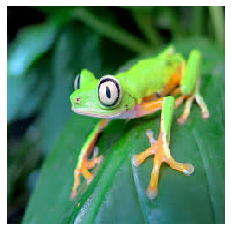

In [20]:
plt.imshow(image.load_img(frog_path, target_size=(224, 224)))
plt.axis('off');

In [21]:
img_contains(test_frog, 'frog')

True

In [22]:
img_contains_prob(test_frog, 'frog')

0.9755535740041523

In [23]:
img_contains_prob(test_frog, 'fish')

0

In [24]:
fish_path = ('C:\\Users\\aloha\\Downloads\\Elizabeth\\Lambda School\\'
            'downloads\\lily frog pond\\test_fish.jpg')
test_fish = process_img_path(fish_path)

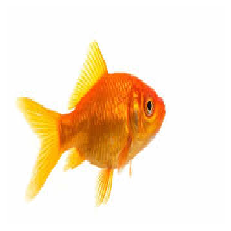

In [25]:
plt.imshow(image.load_img(fish_path, target_size=(224, 224)))
plt.axis('off');

In [26]:
img_contains(test_fish, 'fish')

True

In [27]:
img_contains_prob(test_fish, 'fish')

0.9999853738396496

In [28]:
predict_top_n(test_fish, 10)

[('n01443537', 'goldfish', 0.9999851),
 ('n01440764', 'tench', 8.814234e-06),
 ('n02606052', 'rock_beauty', 4.148702e-06),
 ('n02514041', 'barracouta', 5.538512e-07),
 ('n03935335', 'piggy_bank', 3.4630608e-07),
 ('n02607072', 'anemone_fish', 2.7500084e-07),
 ('n01496331', 'electric_ray', 2.7338953e-07),
 ('n04579432', 'whistle', 2.4076434e-07),
 ('n01818515', 'macaw', 1.1642514e-07),
 ('n02655020', 'puffer', 1.0478817e-07)]

So we got lucky on this particular test image, but in general it looks like we'd need to know all of the fish species for which ResNet-50 has categories to effectively use this approach.

In [29]:
img_contains(test_fish, 'frog')

False

In [30]:
img_contains_prob(test_fish, 'frog')

0

In [31]:
combo_path = ('C:\\Users\\aloha\\Downloads\\Elizabeth\\Lambda School\\'
              'downloads\\lily frog pond\\frog_turtle.jpg')
test_combo = process_img_path(combo_path)

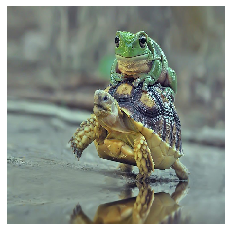

In [32]:
plt.imshow(image.load_img(combo_path, target_size=(224, 224)))
plt.axis('off');

In [33]:
img_contains(test_combo, 'frog')

False

In [34]:
img_contains_prob(test_combo, 'frog')

0.03918059915304184

In [35]:
img_contains(test_combo, 'turtle')

False

In [36]:
img_contains_prob(test_combo, 'turtle')

0

In [37]:
# What DOES ResNet50 think this is a picture of?
predict_top_n(test_combo, 10)

[('n01687978', 'agama', 0.1697339),
 ('n01693334', 'green_lizard', 0.15169196),
 ('n01677366', 'common_iguana', 0.14549573),
 ('n01694178', 'African_chameleon', 0.059867132),
 ('n01688243', 'frilled_lizard', 0.044394832),
 ('n01641577', 'bullfrog', 0.0391806),
 ('n01770393', 'scorpion', 0.034098417),
 ('n01978455', 'rock_crab', 0.033419624),
 ('n01682714', 'American_chameleon', 0.03096194),
 ('n01695060', 'Komodo_dragon', 0.02984701)]

ResNet50 doesn't so much look for what an image _contains_ as what it is _of_ - it's easily confused by images with multiple distinct subjects.

#### Stretch Goal: Displaying Predictions

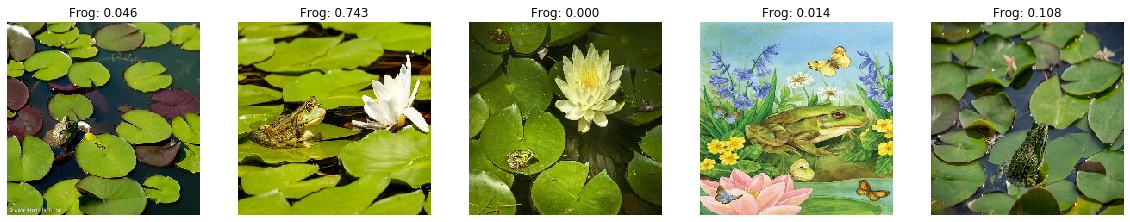

In [42]:
images = [image.load_img(path, target_size=(224, 224)) for path in 
         absolute_image_paths[0]['lily frog pond']]

cols = 5
rows = 1
fig=plt.figure(figsize=(20, 20))
for idx, img in enumerate(images):
    processed_img = process_img_path(
        absolute_image_paths[0]['lily frog pond'][idx])
    fig.add_subplot(rows, cols, idx+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Frog: {img_contains_prob(processed_img, 'frog'):.3f}")
plt.show()

<a id="p3"></a>
## Part 3 - Autoencoders

Describe a use case for an autoencoder given that an autoencoder tries to predict its own input. 

__*Your Answer:*__ Autoencoders can be used for anomaly detection, taking a high reconstruction error relative to the model's typical performance as an indicator of anomalous input. They can also be used for dimensionality reduction (useful for visualization of high-dimensional data), in which application they work a bit like a non-linear form of principal component analysis (PCA). Image denoising is a third use case for autoencoders.

<a id="p4"></a>
## Part 4 - More...

Answer the following questions, with a target audience of a fellow data scientist:

- What do you consider your strongest area, as a data scientist?

> I'm good at working on a team with non-technical people: defining the problem, asking clarifying questions, laying out the pros and cons of potential approaches, prototyping to get early feedback and making adjustments, considering edge cases and designing appropriate tests, etc. I can also write SQL in my sleep.

- What area of data science would you most like to learn more about, and why?

> As a former math major, I'm pretty confident with the basics, but I'd like to gain a deeper and more sophisticated grasp of statistical methods and analysis. I think statistical literacy is really fundamental to understanding any data science problem, and I think it's key to avoiding doing nothing much (or in cases of biased learning, etc., potentially worse than nothing!) in expensive and complicated ways.

> My second choice would be natural language processing. Leading into the next question a bit, I have a feeling it's an area that will see significant advances in the next few years - I think current technology, used creatively and cleverly, is _already_ sufficient for us to see better results than we do now. Plus I have some past experience and interest in _human_ translation, which adds to the interest factor here.

- Where do you think data science will be in 5 years?

> As a generalization of my thoughts about natural language processing, above, I think we'll some interesting variations in the degree of integration and isolation between what we might call "pure" data science and domain-specific heuristics and techniques. Tools like Keras and spaCy will continue to make complex algorithms more accessible to domain experts, and I think we'll see even simpler and more graphical interfaces developed for them. I think we'll see more and better automated hyperparameter tuning and model selection tools, too.

- What are the threats posed by AI to our society?

>Humanity as a whole is amazingly good at maximizing the wrong function (cf. the climate apocalypse). AI makes us even better (and faster) at it.

- How do you think we can counteract those threats? 

> Universal basic income. The twenty-hour work week. New secular religions. Philosophy and ethics courses at the elementary and secondary school levels. Ordinary people having the time and space and security to slow down and really think about what they're doing - and to make choices without those choices being warped by the economic and social pressures of our current society. More generally, some kind of post-capitalist system of incentives - and possibly some kind of post-democratic system of governance as well.

> (I'm not saying we should try Heinlein's quadratic equation plan, but I _am_ super curious what would happen if we did. :P I'm also curious what would happen if voters had to pass a short quiz on the candidates' stated positions - perhaps first selecting a topic _they_ considered important - before being allowed to cast a vote for any candidate.)

> Alternatively, you know, it could be fun to try and build our AI-enhanced society GAN style - set _this_ AI to predict the ultimate consequences of our use of _that_ AI, etc., etc.

> Or, given the vagaries of human nature, perhaps a more reliable way of approaching the goals the economic and political reforms suggested i my first paragraph are meant to support would be values-based AI decision systems for individuals - you specify your values and their relative importance to you; the AI suggests a course of action. (Conversely, such a system might also be able to infer your true values from your _actual_ actions, allowing you to compare these to your stated/intended values and re-evaluate accordingly.)

- Do you think achieving General Artifical Intelligence will ever be possible?

> I think this is something that could perhaps evolve in tandem with robotics, as computing systems become more able to experience and interact with what they can now only reason about abstractly.

A few sentences per answer is fine - only elaborate if time allows.

## Congratulations! 

Thank you for your hard work, and congratulations! You've learned a lot, and you should proudly call yourself a data scientist.